In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
save_dir = "diffusion_training_data/"
#save_dir = '/content/drive/MyDrive/ai ai pong/'+ save_dir


In [5]:
from torchvision.models import resnet18
encoder = resnet18(weights="IMAGENET1K_V1")
# #remove the fully connected layers
encoder.fc = nn.Identity()

#test it
encoder.eval()
x = torch.randn(1, 3, 224, 224) # will need to convert pong images from 160 and 210 to this size of 224,224 later.
with torch.no_grad():
    y = encoder(x)
    print(y.shape)

torch.Size([1, 512])


In [1]:
!pip install diffusers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 82.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.1/774.1 kB 19.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 56.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.8 MB/s eta 0:00:00


In [5]:
# !pip install torchvision
# !pip install tensorboard
# !pip uninstall conditional_diffusion

#install torch with cuda
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/stevenharperja/conditional_diffusion.git#egg=conditional_diffusion


Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/stevenharperja/conditional_diffusion.git to c:\users\shwes\appdata\local\temp\pip-install-87xbmn9y\conditional-diffusion_7d2e550f9e564440a071f1a5277ce0dc
  Resolved https://github.com/stevenharperja/conditional_diffusion.git to commit ce480bac794a41df4a5e88f5d7e04dba876b7fc4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/stevenharperja/conditional_diffusion.git 'C:\Users\shwes\AppData\Local\Temp\pip-install-87xbmn9y\conditional-diffusion_7d2e550f9e564440a071f1a5277ce0dc'


In [6]:
torch.cuda.is_available()
import torch

09:02:32 - INFO: Sampling 1 new images....
999it [00:35, 28.41it/s]


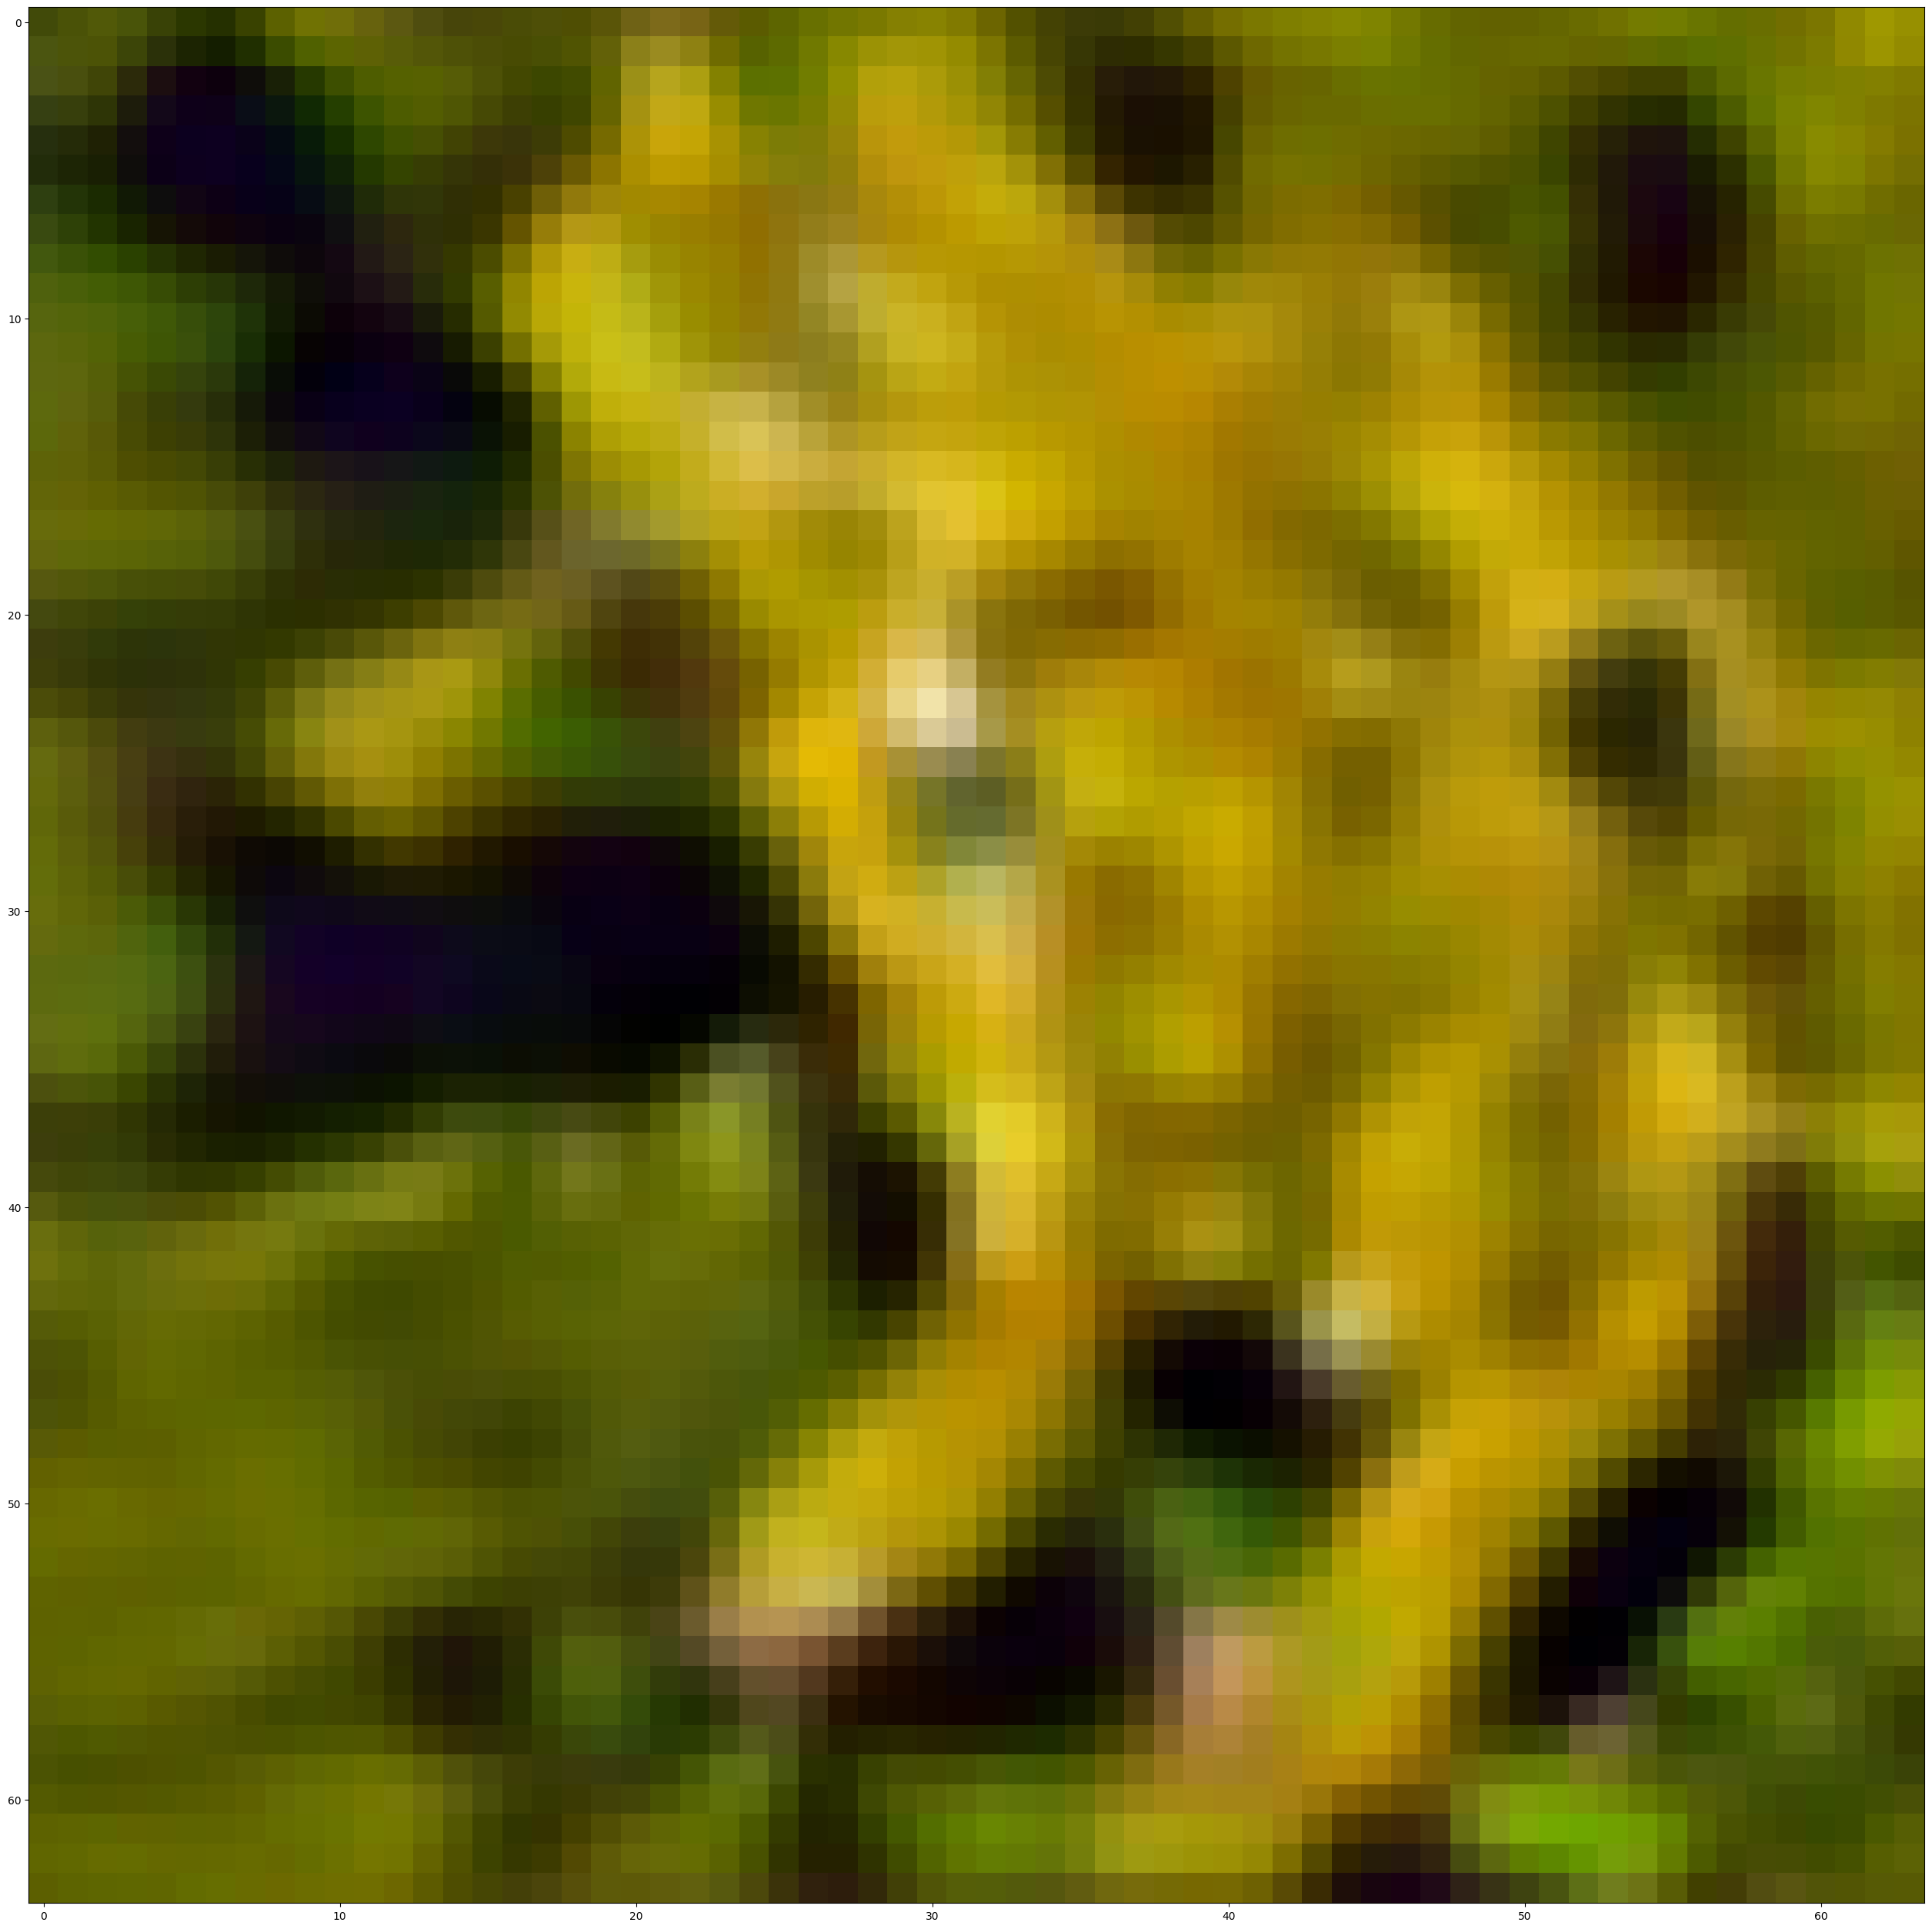

In [10]:
#import modules #dont need it.
import conditional_diffusion.modules as modules
from conditional_diffusion.ddpm_conditional import Diffusion as Diffusion
import conditional_diffusion.utils as utils
import torch



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n = 1

model = modules.UNet_conditional(num_classes=10).to(device)
ckpt = torch.load("models/conditional_ema_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)

#Y is embedding
y = torch.Tensor([6] * n).long().to(device)
#X is image
x = diffusion.sample(model, n, y, cfg_scale=3)
utils.plot_images(x)

In [15]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        resnet = resnet50(weights="IMAGENET1K_V2").fc = nn.Identity()
        #freeze the weights for resnet
        for param in resnet.parameters():
            param.requires_grad = False

        #input of (N, 3, 224, 224), output of (N, 2048)
        self.encoder = resnet
        #input of (N, ????), output of (N, 1, 256, 256)
        self.generator = nn.Sequential(
            #<diffusion model>, # placeholder for diffusion model
            nn.conv2d(in_channels=3, out_channels=1, kernel_size=1, stride=1, padding=0), # reduce channel size to 1 for black and white
        )
        #input of (N, 2048), output of (N, 1)
        self.reward_maker = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1),
        )
        #input of (N, 2048), output of (N, 1)
        self.done_maker = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1),
        )

    def forward(self, x):
        embedding = self.encoder(x)
        image = self.generator(embedding) #(n,1,256,256)
        rew = self.done_maker(embedding) #(n,1)
        don = self.reward_maker(embedding) #(n,1)
        return image,rew,don


In [ ]:
# Create an instance of the network
net = Net().to(device)

In [17]:
#see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# define loss function and optimizer
import torch.optim as optim

img_criterion = nn.MSELoss()
rew_criterion = nn.MSELoss()
don_criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


image_importance = 10 #hyperparameter for weighting how important the image is in the loss function.


In [21]:
from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
from os import listdir
from os.path import isfile, join

class PongDataset(Dataset):
    def __init__(self, dir, device):
        self.dir = dir
        self.device = device
    def __len__(self):
        existing_files = [f for f in listdir(self.dir) if isfile(join(self.dir, f))]
        if existing_files:
            #This grabs the largest integer out of all the filenames (filter the string for digit chars, convert those chars to an int)
            i = max(*[int(''.join([i for i in f if i.isdigit()])) for f in existing_files])
            return i
        else:
            return 0
    def __getitem__(self, index):
        # transitions = np.load(save_dir + "transitions{i}.npz".format(index))
        # observations = transitions["observations"]
        # actions = transitions["actions"]
        # rewards = transitions["rewards"]
        # dones = transitions["dones"]

        #use data which was preformatted for the 'trivial' model
        input = torch.load(self.dir+"input{i}.pt".format(i=index)).to(self.device)
        truth = torch.load(self.dir+"truth{i}.pt".format(i=index))
        truth = tuple([t.to(self.device)for t in truth])

        return input, truth 

In [22]:
batch_size = 4
trainset = PongDataset(save_dir,device)
if __name__ == '__main__':
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)#, num_workers=1)

In [23]:

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print(i)
        input, truth = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        img,r,d = net(input)
        loss1 = img_criterion(img,truth[0])
        loss2 = rew_criterion(r,truth[1])
        loss3 = don_criterion(d,truth[2])
        loss = loss1#(image_importance * loss1) + loss2 + loss3
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

0


C:\Users\shwes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Finished Training


C:\Users\shwes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [24]:
PATH = './models/pong_gen.pth'
torch.save(net.state_dict(), PATH)

In [25]:
net = Net(hidden_channels=hidden_channels)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
output = net(input[0].unsqueeze(0))[0]
print(output.shape)

torch.Size([1, 1, 210, 160])


In [33]:
from PIL import Image
image = Image.fromarray(input[0][0].cpu().detach().numpy())# true value
image.show()

image = Image.fromarray(output[0][0].cpu().detach().numpy())# predicted value
image.show()
print(output[0][0].cpu().detach().numpy())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
gif = []
images = [Image.fromarray(observation) for observation in observations]
for image in images:
    gif.append(image)
gif[0].save('temp/result.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)

NameError: name 'observations' is not defined